In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import autoregression
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
df = pd.read_csv('/Users/ElliottC/g/projects/yelp/predicting_restaurant_closure/data/featurized_dataframe.csv')

In [75]:
y_true = df[['closed_on_google']]
yelp_columns = ['restaurant_count','review_count','stars',
    'Attribute|has_Alcohol', 'Attribute|has_Ambience|casual', 'Attribute|has_Ambience|classy', 
                'Attribute|has_Ambience|divey', 'Attribute|has_Ambience|hipster', 
                'Attribute|has_Ambience|intimate', 'Attribute|has_Ambience|romantic', 
                'Attribute|has_Ambience|touristy', 'Attribute|has_Ambience|trendy', 
                'Attribute|has_Ambience|upscale', 'Attribute|has_BikeParking', 
                'Attribute|has_BusinessAcceptsCreditCards', 'Attribute|has_BusinessParking|garage', 
                'Attribute|has_BusinessParking|lot', 'Attribute|has_BusinessParking|street', 
                'Attribute|has_BusinessParking|valet', 'Attribute|has_BusinessParking|validated', 
                'Attribute|has_Caters', 'Attribute|has_CoatCheck', 'Attribute|has_DogsAllowed', 
                'Attribute|has_DriveThru', 'Attribute|has_GoodForDancing', 'Attribute|has_GoodForKids', 
                'Attribute|has_GoodForMeal|breakfast', 'Attribute|has_GoodForMeal|brunch', 
                'Attribute|has_GoodForMeal|dessert', 'Attribute|has_GoodForMeal|dinner', 
                'Attribute|has_GoodForMeal|latenight', 'Attribute|has_GoodForMeal|lunch', 
                'Attribute|has_HappyHour', 'Attribute|has_HasTV', 'Attribute|has_Music|background_music', 
                'Attribute|has_Music|dj', 'Attribute|has_Music|jukebox', 'Attribute|has_Music|karaoke', 
                'Attribute|has_Music|live', 'Attribute|has_Music|no_music', 'Attribute|has_Music|video', 
                'Attribute|has_NoiseLevel', 'Attribute|has_OutdoorSeating', 'Attribute|has_RestaurantsAttire', 
                'Attribute|has_RestaurantsDelivery', 'Attribute|has_RestaurantsGoodForGroups', 
                'Attribute|has_RestaurantsPriceRange2', 'Attribute|has_RestaurantsReservations', 
                'Attribute|has_RestaurantsTableService', 'Attribute|has_RestaurantsTakeOut', 
                'Attribute|has_Smoking', 'Attribute|has_WheelchairAccessible', 'Attribute|has_WiFi', 
                'Category|American (New)_true', 'Category|American (Traditional)_true', 
                'Category|Arts & Entertainment_true', 'Category|Asian Fusion_true', 
                'Category|Automotive_true', 'Category|Bakeries_true', 'Category|Barbeque_true', 
                'Category|Bars_true', 'Category|Beer_true', 'Category|Breakfast & Brunch_true', 
                'Category|Burgers_true', 'Category|Cafes_true', 'Category|Caterers_true', 
                'Category|Chicken Wings_true', 'Category|Chinese_true', 'Category|Cocktail Bars_true',
                'Category|Coffee & Tea_true', 'Category|Convenience Stores_true', 'Category|Delis_true', 
                'Category|Desserts_true', 'Category|Diners_true', 'Category|Drugstores_true', 
                'Category|Event Planning & Services_true', 'Category|Fast Food_true', 
                'Category|Food Trucks_true', 'Category|Food_true', 'Category|Gas Stations_true', 
                'Category|Grocery_true', 'Category|Ice Cream & Frozen Yogurt_true', 
                'Category|Italian_true', 'Category|Japanese_true', 'Category|Juice Bars & Smoothies_true', 
                'Category|Lounges_true', 'Category|Mediterranean_true', 'Category|Mexican_true', 
                'Category|Nightlife_true', 'Category|Pizza_true', 'Category|Pubs_true', 
                'Category|Restaurants_true', 'Category|Salad_true', 'Category|Sandwiches_true', 
                'Category|Seafood_true', 'Category|Shopping_true', 'Category|Specialty Food_true', 
                'Category|Sports Bars_true', 'Category|Steakhouses_true', 'Category|Sushi Bars_true', 
                'Category|Tex-Mex_true', 'Category|Wine & Spirits_true', 'Category|Wine Bars_true']

census_columns = ['2016 ACS 5-Year Population Estimate',
                 'American Indian and Alaska Native alone',
                 'Asian alone',
                 'Black or African American alone',
                 'Census 2010 Total Population',
                 'Educational Attainment: Percent high school graduate or higher',
                 'Foreign Born Population',
                 'Hispanic or Latino (of any race)',
                 'Individuals below poverty level',
                 'Median Age',
                 'Median Household Income',
                 'Native Hawaiian and Other Pacific Islander alone',
                 'Some Other Race alone',
                 'Total housing units',
                 'Two or More Races',
                 'Veterans',
                 'White alone',
                 'White alone, Not Hispanic or Latino']

x_columns = df[yelp_columns + census_columns]

X_train, X_test, y_train, y_test = train_test_split(x_columns, y_true, test_size=0.33, random_state=42)

model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

/Users/ElliottC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

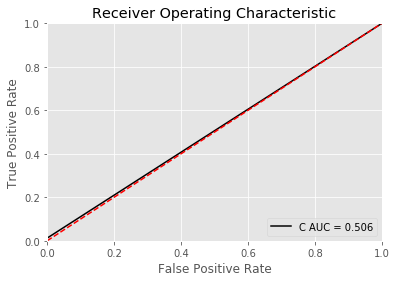

In [76]:
y_true = y_test
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_true, y_pred)
area_under_curve = auc(fpr, tpr)

# method I: plt
fig, ax = plt.subplots()
plt.title('Receiver Operating Characteristic')
ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

<Container object of 20 artists>

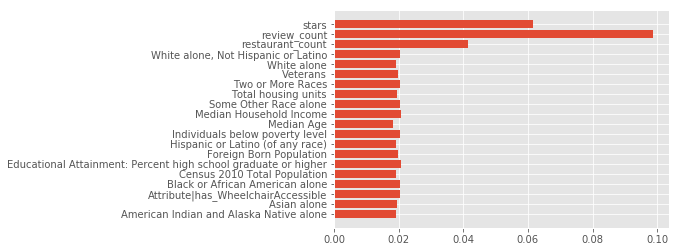

In [61]:
feature_values = {}
for i in range(len(model.feature_importances_)):
    feature_values[x_columns.columns[i]] = model.feature_importances_[i]

top_features = sorted(feature_values.items(), key=lambda x: x[1], reverse=True)[:20]

features = [feature[0] for feature in top_features]
values = [feature[1] for feature in top_features]
fig, ax = plt.subplots()
ax.barh(features, values)

In [64]:
df['closed_on_google'].sum()

677